Implementing an Autoencoder in PyTorch
===

This is adapted from the workbook provided alongside the article "Implementing an Autoencoder in Pytorch" which can be found [here](https://medium.com/pytorch/implementing-an-autoencoder-in-pytorch-19baa22647d1). The primary differences are that the network is much larger (as the code is designed to work with much larger images) and the model is split into two parts to allow for differential encode/decode metrics such as Mahalanobis Distance.

This version of the model is designed with a convolutional model.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import math
import numpy
import collections

from model import SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder


Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
print(platform)

cuda


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

batch_size = 16
epochs = 80
learning_rate = 1e-4

#code_size = 100
code_sides = [16]

convolution_filters = 4

#image_count = 300
image_count = -1

validation_split = 0.9

## Dataset

ImageFolder is used to load the base distribution images

In [4]:
from torchvision.datasets import ImageFolder

from torchvision.transforms import ToTensor,Grayscale
transform = torchvision.transforms.Compose([
     torchvision.transforms.Grayscale(),
#     torchvision.transforms.Resize((height,width)),
     torchvision.transforms.ToTensor()
    ])

root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/256"
train_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform)
if (image_count == -1):
    train_dataset_subset = train_dataset
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

dataset_len = len(train_dataset_subset)
indices = list(range(dataset_len))

# Randomly splitting indices:
val_len = int(np.floor((1.0 - validation_split) * dataset_len))

dataset_size = len(train_dataset_subset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
    
train_loader = torch.utils.data.DataLoader(
    train_dataset_subset, batch_size=batch_size, sampler = train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    train_dataset_subset, batch_size=batch_size, sampler = valid_sampler
)

data_loaders = {"train": train_loader, "val": valid_loader}
data_lengths = {"train": split, "val": val_len}
print(split)
print(val_len)

3309
367


In [5]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu

models = []
optimizers = []

for i in range(len(code_sides)):
    code_size = code_sides[i] * code_sides[i]
    models.append(SplitAutoencoder(input_shape=(height,width),code_size=code_size,convolutions=convolution_filters).to(device))
    optimizers.append(optim.Adam(models[i].parameters(), lr=learning_rate))

# mean-squared error loss
criterion = nn.MSELoss()
#criterion = nn.BCELoss()

We train our autoencoder for our specified number of epochs.

In [6]:
best_model_dicts = []
# populate with fake best models
for i in range(len(code_sides)):
    best_model_dicts.append((1.0,None))

train_losses = []
val_losses = []
    
for i in range(len(code_sides)):
    print("==================")
    print("Running for code size:" + str(code_sides[i] * code_sides[i]))
    
    train_losses.append([])
    val_losses.append([])
    
    for epoch in range(epochs):
        losses = {'train':0.0, 'val':0.0}
       
        for phase in ['train', 'val']:
            if phase == 'train':
                models[i].train()  # Set model to training mode
            else:
                models[i].eval()  # Set model to evaluate mode

            for batch_features, labels in data_loaders[phase]:
                # load it to the active device
                batch_features = batch_features.to(device)

                # reset the gradients back to zero
                # PyTorch accumulates gradients on subsequent backward passes
                optimizers[i].zero_grad()

                # compute reconstructions
                codes = models[i].encoder(batch_features)
                outputs = models[i].decoder(codes)

                # compute training reconstruction loss
                local_loss = criterion(outputs,batch_features)

                if phase == 'train':
                    # compute accumulated gradients
                    local_loss.backward()

                    # perform parameter update based on current gradients
                    optimizers[i].step()

                # add the mini-batch training loss to epoch loss
                losses[phase] += local_loss.item()

        # compute the epoch training loss
        #losses['train'] = losses['train'] / data_lengths['train']
        #losses['val'] = losses['val'] / data_lengths['val']

        losses['train'] = losses['train'] / len(data_loaders['train'])
        losses['val'] = losses['val'] / len(data_loaders['val'])

        #check if best model
        if(losses['val'] < best_model_dicts[i][0]):
            best_model_dicts[i] = (losses['val'],models[i].state_dict())
        
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        
        # display the epoch training loss
        print("epoch : {}/{}, train loss = {:.8f}, validation loss = {:.8f}".format(epoch + 1, epochs, losses['train'],losses['val']))
    

Running for code size:256


C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


epoch : 1/80, train loss = 0.27003667, validation loss = 0.11585102
epoch : 2/80, train loss = 0.08175793, validation loss = 0.07023846
epoch : 3/80, train loss = 0.06488835, validation loss = 0.05918309
epoch : 4/80, train loss = 0.05485734, validation loss = 0.05210969
epoch : 5/80, train loss = 0.04938433, validation loss = 0.04690723
epoch : 6/80, train loss = 0.04375656, validation loss = 0.04170958
epoch : 7/80, train loss = 0.03683196, validation loss = 0.03420297
epoch : 8/80, train loss = 0.03032460, validation loss = 0.02847361
epoch : 9/80, train loss = 0.02614965, validation loss = 0.02560242
epoch : 10/80, train loss = 0.02326932, validation loss = 0.02347192
epoch : 11/80, train loss = 0.02095196, validation loss = 0.02195259
epoch : 12/80, train loss = 0.01929093, validation loss = 0.02050627
epoch : 13/80, train loss = 0.01783762, validation loss = 0.01934049
epoch : 14/80, train loss = 0.01663535, validation loss = 0.01851131
epoch : 15/80, train loss = 0.01553956, val

Restore the best trained model and save.

In [7]:
for i in range(len(code_sides)):
    models[i].load_state_dict(best_model_dicts[i][1])
    PATH = "../../Data/OPTIMAM_NEW/model" + str(i) + ".pt"
    torch.save(models[i], PATH)

Let's extract some test examples to reconstruct using our trained autoencoder.

In [8]:
root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/256"
test_dataset = torchvision.datasets.ImageFolder(root=root_dir, transform=transform) # same transform as we used for the training, for compatibility

if (image_count == -1):
    test_dataset_subset = test_dataset
else:
    test_dataset_subset = torch.utils.data.Subset(test_dataset, numpy.random.choice(len(test_dataset), image_count, replace=False))

test_loader = torch.utils.data.DataLoader(
    test_dataset_subset, batch_size=5, shuffle=True
)

test_example_sets = [None] * len(code_sides)
code_sets = [None] * len(code_sides)
reconstruction_sets = [None] * len(code_sides)

## Visualize Results

Let's try to reconstruct some test images using our trained autoencoder.

In [9]:
with torch.no_grad():
    for i in range(len(code_sides)):
        for batch_features in test_loader:
            batch_features = batch_features[0]
            test_examples = batch_features.to(device)
            n_codes = models[i].encoder(test_examples)
            reconstruction = models[i](test_examples)
            break;
        test_example_sets[i] = test_examples
        code_sets[i] = n_codes
        reconstruction_sets[i] = reconstruction

            

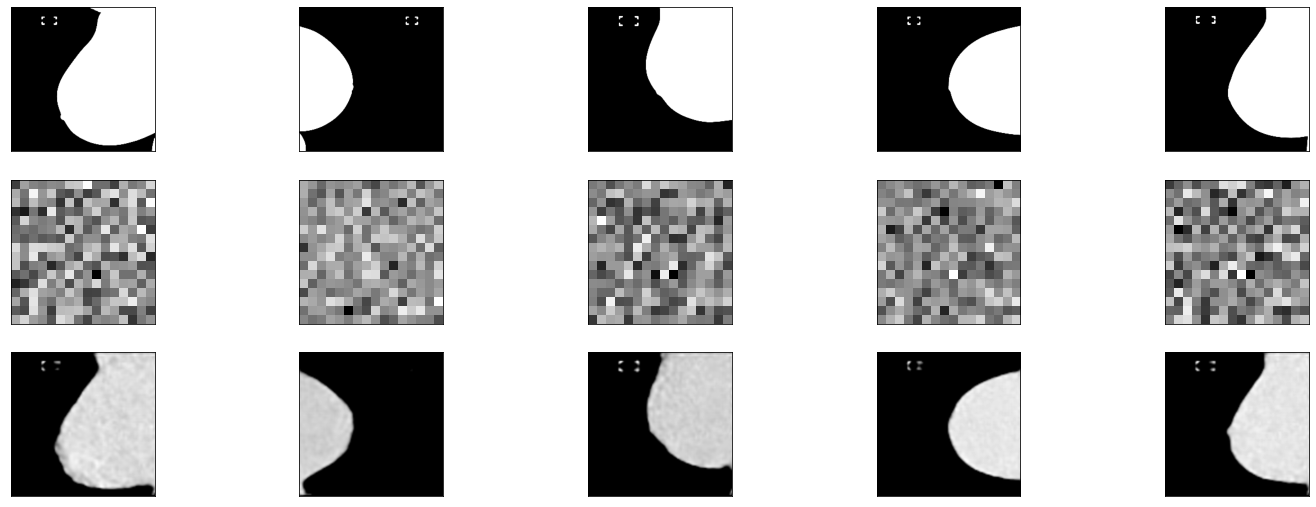

In [10]:
with torch.no_grad():
    for i in range(len(code_sides)):
        number = 5
        plt.figure(figsize=(25, 9))
        for index in range(number):
            # display original
            ax = plt.subplot(3, number, index + 1)
            test_examples = test_example_sets[i]
            copyback = test_examples[index].cpu()
            #plt.imshow(copyback.numpy().reshape(height, width), vmin=0, vmax=65535)
            plt.imshow(copyback.reshape(height, width))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display codes
            ax = plt.subplot(3, number, index + 1 + number)
            codes = code_sets[i]
            code_copyback = codes[index].cpu()
            plt.imshow(code_copyback.numpy().reshape(code_sides[i],code_sides[i]))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(3, number, index + 6 + number)
            reconstruction = reconstruction_sets[i]
            recon_copyback = reconstruction[index].cpu()
            plt.imshow(recon_copyback.reshape(height, width))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        out_path = "output"+str(i)+".png" 
        plt.savefig(out_path)
        plt.show()